# Swollen cylinder compression 

- Swelling and subsequent compression of a gel cylinder
- This is an axisymmetric simulation

# Degrees of freedom
- Displacement: u
- pressure: p
- chemical potential: mu
- concentration: c

# Units
- Length: mm
- Mass: kg
- Time: s
- Mass density: kg/mm^3
- Force: milliN
- Stress: kPa 
- Energy: microJ
- Temperature: K
- Amount of substance: mol
- Species concentration: mol/mm^3
- Chemical potential: milliJ/mol
- Molar volume: mm^3/mol
- Species diffusivity: mm^2/s
- Gas constant: microJ/(mol K)

### Software:
- Dolfinx v0.8.0


In the collection "Example Codes for Coupled Theories in Solid Mechanics,"

By Eric M. Stewart, Shawn A. Chester, and Lallit Anand.

https://solidmechanicscoupledtheories.github.io/

# Import modules

In [1]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile

# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 gt, dx, inner, derivative, dot, ln, split, exp, eq, cos, sin, acos, ge, le, outer, tanh,\
                 cosh, atan, atan2)

# basix finite elements (necessary for dolfinx v0.8.0)
import basix
from basix.ufl import element, mixed_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime

# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [2]:
# Create mesh 
R0 = 2.5  # radius of bar
H0 = 2.5  # height of bar
domain = mesh.create_rectangle(MPI.COMM_WORLD, [[0.0,0.0], [R0,H0]],\
                         [8,8], mesh.CellType.triangle, diagonal=mesh.DiagonalType.crossed)

x = ufl.SpatialCoordinate(domain)

**Identify boundaries of the domain**

In [3]:
# Identify the boundaries of the  rectangle mesh
#
def xBot(x):
    return np.isclose(x[0], 0)
def xTop(x):
    return np.isclose(x[0], R0)
def yBot(x):
    return np.isclose(x[1], 0)
def yTop(x):
    return np.isclose(x[1], H0)
    
# Mark the sub-domains
boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop)]

# Identify the bottom left corner
def Ground(x):
        return np.isclose(x[0], 0) and np.isclose(x[1], 0)


# Build collections of facets on each subdomain and mark them appropriately.
facet_indices, facet_markers = [], [] # initalize empty collections of indices and markers.
fdim = domain.topology.dim - 1 # geometric dimension of the facet (mesh dimension - 1)
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator) # an array of all the facets in a 
                                                         # given subdomain ("locator")
    facet_indices.append(facets)                         # add these facets to the collection.
    facet_markers.append(np.full_like(facets, marker))   # mark them with the appropriate index.

# Format the facet indices and markers as required for use in dolfinx.
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
# 
# Add these marked facets as "mesh tags" for later use in BCs.
facet_tags = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

**Visualize reference configuration**

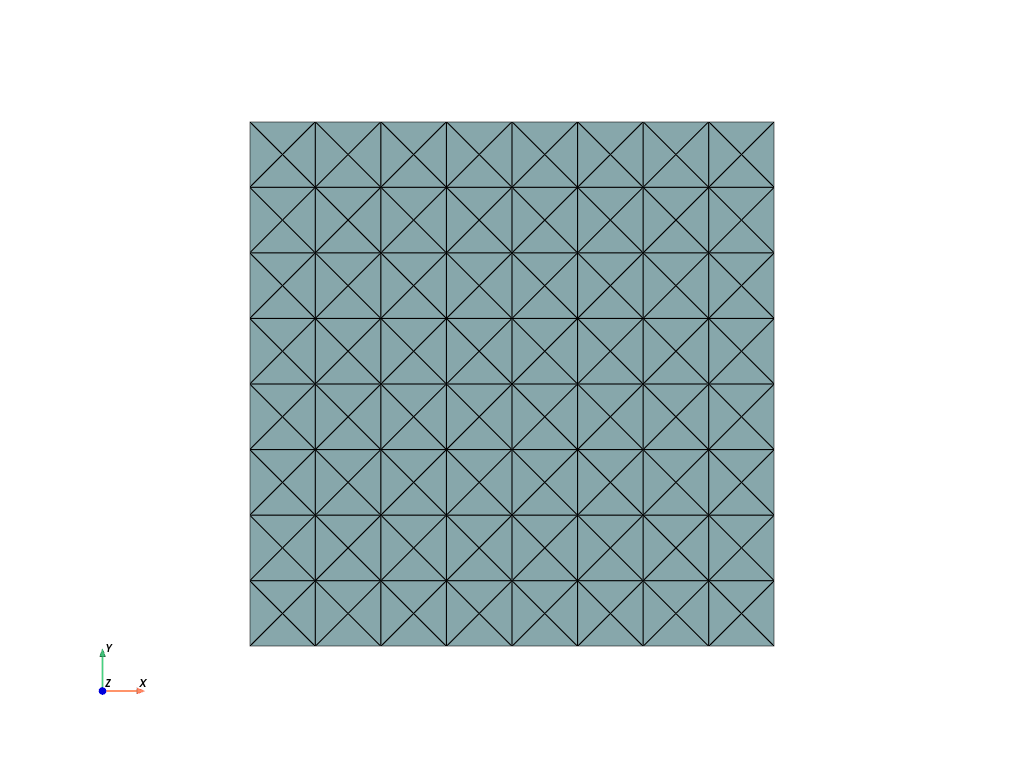

In [4]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()

# Add the mesh.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter.add_mesh(grid, show_edges=True) 

plotter.view_xy()

#labels = dict(xlabel='X', ylabel='Y',zlabel='Z')
labels = dict(xlabel='X', ylabel='Y')
plotter.add_axes(**labels)

plotter.screenshot("results/bar_mesh.png")

from IPython.display import Image
Image(filename='results/bar_mesh.png') 

# # Use the following  commands for a  zoom-able  view
# if not pyvista.OFF_SCREEN:
#     plotter.show()
# else:
#     plotter.screenshot("axi_cylinder_mesh.png")


## Define boundary and volume integration measure

In [5]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':4})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, metadata={'quadrature_degree': 4})

# Create facet to cell connectivity required to determine boundary facets.
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim)
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)
domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)

# #  Define facet normal
n2D = ufl.FacetNormal(domain)
n = ufl.as_vector([n2D[0], n2D[1], 0.0]) # define n as a 3D vector for later use

# Material parameters

In [6]:
# Set the locking stretch to a large number to model a Neo-Hookean material
#
Gshear_0= Constant(domain,PETSc.ScalarType(1000.0))         # Shear modulus, kPa
lambdaL = Constant(domain,PETSc.ScalarType(1.e6))           # Locking stretch, Neo-Hookean material
Kbulk   = Constant(domain,PETSc.ScalarType(1000*Gshear_0))  # Bulk modulus, kPa
Omega   = Constant(domain,PETSc.ScalarType(1.00e5))         # Molar volume of fluid
D       = Constant(domain,PETSc.ScalarType(5.00e-3))        # Diffusivity
chi     = Constant(domain,PETSc.ScalarType(0.1))            # Flory-Huggins mixing parameter
theta0  = Constant(domain,PETSc.ScalarType(298) )           # Reference temperature
R_gas   = Constant(domain,PETSc.ScalarType(8.3145e6))       # Gas constant
RT      = Constant(domain,PETSc.ScalarType(8.3145e6*theta0))
#
phi0    = Constant(domain,PETSc.ScalarType(0.999))                # Initial polymer volume fraction
mu0     = Constant(domain,PETSc.ScalarType(ln(1.0-phi0) + phi0 )) # Initial chemical potential
c0      = Constant(domain,PETSc.ScalarType((1/phi0) - 1))         # Initial concentration

# Simulation time-control related parameters

In [7]:
t    = 0.0        # initialization of time
tSwell = 3600.0*24.0 # time for swelling
tCompress = 3600.0*2.0 # time for compression
tHold = 3600.0*6.0 # holding time after compression
Ttot = tSwell + tCompress + tHold # total simulation time 
ttd  = 300        # Decay time constant
dt   = 100        # Initial step size

# Boundary condition expression for increasing  the chemical potential
#
def muRamp(t):
    return mu0*exp(-t/ttd)

# Function to control the platen displacement
def dispRamp(t):
    if t <= tSwell:
        disp = 0.0
    elif t>tSwell+tCompress:
        disp = -1.5
    else:
        disp = -1.5*(t-tSwell)/tCompress
    return disp

# Function spaces

In [8]:
# Define function space, both vectorial and scalar
# 
U2 = element("Lagrange", domain.basix_cell(), 2, shape=(2,)) # For displacement
P1 = element("Lagrange", domain.basix_cell(), 1) # For pressure, chemical potential and  species concentration
#                                      
TH = mixed_element([U2, P1, P1, P1])  # Taylor-Hood style mixed element
ME = functionspace(domain, TH)        # Total space for all DOFs

# Define actual functions with the required DOFs
w = Function(ME)
u, p, mu, c = split(w)  # displacement u, pressure p, chemical potential mu, and concentration c

# A copy of functions to store values in the previous step for time-stepping
w_old = Function(ME)
u_old,  p_old, mu_old, c_old = split(w_old)   

# Define test functions    
u_test, p_test,  mu_test, c_test = TestFunctions(ME)  

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)                    

# Initial conditions

- The initial conditions for $\mathbf{u}$ and $p$ are zero everywhere.
- These are imposed automatically, since we have not specified any non-zero initial conditions.
- We do, however, need to impose the uniform initial conditions for $\mu=\mu_0$ and $\hat{c} = \hat{c}_0$ which correspond to $\phi_0 = 0.999$. This is done below.

In [9]:
# Assign initial  normalized chemical potential  mu0 to the domain
w.sub(2).interpolate(lambda x: np.full((x.shape[1],),  mu0))
w_old.sub(2).interpolate(lambda x: np.full((x.shape[1],), mu0))  

# Assign initial  value of normalized concentration  c0 to the domain
w.sub(3).interpolate(lambda x: np.full((x.shape[1],),  c0))
w_old.sub(3).interpolate(lambda x: np.full((x.shape[1],), c0))   

# Subroutines for kinematics and constitutive equations

In [10]:
# Special gradient operators for axisymmetric functions 
#
#---------------------------------------------------
# Gradient of vector field u   
#---------------------------------------------------
def axi_grad_vector(u):
    
    grad_u = grad(u)
    
    axi_grad_33_exp = conditional(eq(x[0], 0), 0.0, u[0]/x[0])
    
    axi_grad_u = ufl.as_tensor([[grad_u[0,0], grad_u[0,1], 0],
                  [grad_u[1,0], grad_u[1,1], 0],
                  [0, 0, axi_grad_33_exp]]) 
    
    return axi_grad_u

#---------------------------------------------------
# Gradient of scalar field y
# (just need an extra zero for dimensions to work out)
#---------------------------------------------------
def axi_grad_scalar(y):
    
    grad_y = grad(y)
    
    axi_grad_y = ufl.as_vector([grad_y[0], grad_y[1], 0.])
    
    return axi_grad_y
#---------------------------------------------------
# Axisymmetric deformation gradient 
#---------------------------------------------------
def F_axi_calc(u):
    
    dim = len(u)                # dimension of problem (2)
    
    Id = Identity(dim)          # 2D Identity tensor
    
    F = Id + grad(u)            # 2D Deformation gradient
    
    F33_exp =  1.0 + u[0]/x[0]  # axisymmetric F33, R/R0 
    
    F33 = conditional(eq(x[0], 0.0), 1.0, F33_exp) # avoid divide by zero at r=0
      
    F_axi =  ufl.as_tensor([[F[0,0], F[0,1], 0],
                  [F[1,0], F[1,1], 0],
                  [0, 0, F33]]) # Full axisymmetric F
    
    return F_axi

#---------------------------------------------------
# Effective stretch lambdaBar
#---------------------------------------------------
def lambdaBar_calc(u):
    F = F_axi_calc(u)
    C = F.T*F
    I1 = tr(C)
    lambdaBar = sqrt(I1/3.0)
    return lambdaBar

#---------------------------------------------------
# Calculate zeta
#---------------------------------------------------
def zeta_calc(u):
    lambdaBar = lambdaBar_calc(u)
    # Use Pade approximation of Langevin inverse
    z    = lambdaBar/lambdaL
    z    = conditional(gt(z,0.95), 0.95, z) # Keep simulation from blowing up
    beta = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    zeta = (lambdaL/(3*lambdaBar))*beta
    return zeta

#---------------------------------------------------
# Calculate zeta0
#---------------------------------------------------
def zeta0_calc():
    # Use Pade approximation of Langevin inverse (A. Cohen, 1991)
    z    = 1/lambdaL
    z    = conditional(gt(z,0.95), 0.95, z) # Keep from blowing up
    beta0 = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    zeta0 = (lambdaL/3)*beta0
    return zeta0

#---------------------------------------------------
# Subroutine for calculating the elastic jacobian Je
#---------------------------------------------------
def Je_calc(u,c):
    F = F_axi_calc(u)  
    detF = det(F)   
    #
    detFs = 1.0 + c          # = Js
    Je    = (detF/detFs)     # = Je
    return   Je    

#----------------------------------------------
# Subroutine for calculating the Piola  stress
#----------------------------------------------
def Piola_calc(u,p):
    F     = F_axi_calc(u)
    zeta  = zeta_calc(u)
    zeta0 = zeta0_calc()
    Piola = (zeta*F - zeta0*inv(F.T) ) - J*p*inv(F.T)/Gshear_0
    return Piola

#--------------------------------------------------------------
# Subroutine for calculating the normalized species flux
#--------------------------------------------------------------
def Flux_calc(u, mu, c):
    F = F_axi_calc(u) 
    #
    Cinv = inv(F.T*F)
    #
    Mob = (D*c)/(Omega*RT)*Cinv
    #
    Jmat = - RT* Mob * axi_grad_scalar(mu)
    return Jmat

#------------------------------------------------------------- 
# Utility subroutines
#-------------------------------------------------------------

# Macaulay bracket function
def ppos(x):
    return (x+abs(x))/2.

# Evaluate kinematics and constitutive relations

In [11]:
# Kinematics
F = F_axi_calc(u)
J = det(F)  # Total volumetric jacobian
#
lambdaBar = lambdaBar_calc(u)
#
# Elastic volumetric Jacobian
Je     = Je_calc(u,c)                    
Je_old = Je_calc(u_old,c_old)

#  Normalized Piola stress
Piola = Piola_calc(u, p)

#  Normalized species  flux
Jmat = Flux_calc(u, mu, c)

# spatial coordinates, for use in contact penalty
u_var = ufl.variable(u)
x_sp  = ufl.variable(x + u_var)


# Weak forms

In [12]:
# Residuals:
# Res_0: Balance of forces (test fxn: u)
# Res_1: Pressure variable (test fxn: p)
# Res_2: Balance of mass   (test fxn: mu)
# Res_3: Auxiliary variable (test fxn: c)

# Time step field, constant within body
dk = Constant(domain, PETSc.ScalarType(dt))


# The weak form for the equilibrium equation
Res_0 = inner(Piola, axi_grad_vector(u_test) )*x[0]*dx 

# The weak form for the pressure
Res_1 = dot((p*Je/Kbulk + ln(Je)) , p_test)*x[0]*dx
      
# The weak form for the mass balance of solvent      
Res_2 = dot((c - c_old)/dk, mu_test)*x[0]*dx \
        -  Omega*dot(Jmat , axi_grad_scalar(mu_test) )*x[0]*dx

# The weak form for the concentration
fac = 1/(1+c)
fac1 =  mu - ( ln(1.0-fac)+ fac + chi*fac*fac)
fac2 = - (Omega*Je/RT)*p  
fac3 = - (1./2.) * (Omega/(Kbulk*RT)) * ((p*Je)**2.0)
fac4 = fac1 + fac2 + fac3
#
Res_3 = dot(fac4, c_test)*dx


# the penalty energy for contact enforcement
x2Platen = Constant(domain, PETSc.ScalarType(4.5 + dispRamp(0)))
k_pen = Constant(domain, PETSc.ScalarType(1.0e6))
contact_force = 0.5*k_pen*ppos(x[1] + u[1] - x2Platen)
ResContact = dot(contact_force,u_test[1])*ds(4)



# Total weak form
Res = Res_0 + Res_1 + Res_2 + Res_3 + ResContact

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

# Set-up output files

In [13]:
# Set up projection problem for fixing visualization issues
# of fields in  the axisymmetric simulation
#
def setup_projection(u, V):

    trial = ufl.TrialFunction(V)
    test  = ufl.TestFunction(V)   

    a = ufl.inner(trial, test)*x[0]*dx
    L = ufl.inner(u, test)*x[0]*dx

    projection_problem = dolfinx.fem.petsc.LinearProblem(a, L, [], \
        petsc_options={"ksp_type": "cg", "ksp_rtol": 1e-16, "ksp_atol": 1e-16, "ksp_max_it": 1000})
    
    return projection_problem

In [14]:
# results file name
results_name = "gel_axi_compression"

# Function space for projection of results
U1 = element("DG", domain.basix_cell(), 1, shape=(2,))  # For 2d vector
P0 = element("DG", domain.basix_cell(), 1)              # For  scalar 
T1 = element("DG", domain.basix_cell(), 1, shape=(3,3)) # For stress tensor

V1 = fem.functionspace(domain, P0) # Scalar function space
V2 = fem.functionspace(domain, U1) # Vector function space
V3 = fem.functionspace(domain, T1) # Tensor function space

# basic fields to write to output file
u_vis = Function(V2)
u_vis.name = "disp"

p_vis = Function(V1)
p_vis.name = "p"

mu_vis = Function(V1)
mu_vis.name = "mu"

c_vis = Function(V1)
c_vis.name = "c"


# calculated fields to write to output file
phi = 1/(1+c)
phi_vis = Function(V1)
phi_vis.name = "phi"
phi_expr = Expression(phi,V1.element.interpolation_points())

# Project the volumetric Jacobian J for visualization
#
J_projection = setup_projection(J, V1)
J_vis = J_projection.solve()
J_vis.name = "J"

# Project the effective stretch lambdabar for visualization
#
lambdaBar_projection = setup_projection(lambdaBar, V1)
lambdaBar_vis = lambdaBar_projection.solve()
lambdaBar_vis.name = "lambdaBar"

# Project the Piola stress tensor for visualization
#
Piola_projection = setup_projection(Piola, V3)
Piola_temp = Piola_projection.solve()

T   = Piola_temp*F.T/J
T0   = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_projection = setup_projection(Mises, V1)
Mises_vis = Mises_projection.solve()
Mises_vis.name = "Mises"

P11 = Function(V1)
P11.name = "P11"
P11_expr = Expression(Piola_temp[0,0],V1.element.interpolation_points())
P22 = Function(V1)
P22.name = "P22"
P22_expr = Expression(Piola_temp[1,1],V1.element.interpolation_points())
P33 = Function(V1)
P33.name = "P33"
P33_expr = Expression(Piola_temp[2,2],V1.element.interpolation_points())

# set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        u_vis, p_vis, mu_vis, c_vis, phi_vis, J_vis, P11, P22, P33, 
        lambdaBar_vis,Mises_vis,
    ],
    engine="BP4",
)

def writeResults(t):
       
       # Re-project some fields. This is necessary here to remove visual artifacts which arise
       # due to the axisymmetric formulation as r -> 0
       #
       Piola_temp     = Piola_projection.solve()
       Mises_vis      = Mises_projection.solve()
       J_vis          = J_projection.solve()
       lambdaBar_vis  = lambdaBar_projection.solve()

       # Output field interpolation 
       u_vis.interpolate(w.sub(0))
       p_vis.interpolate(w.sub(1))
       mu_vis.interpolate(w.sub(2))
       c_vis.interpolate(w.sub(3))
       phi_vis.interpolate(phi_expr)
       P11.interpolate(P11_expr)
       P22.interpolate(P22_expr)
       P33.interpolate(P33_expr)

       # Write output fields
       file_results.write(t) 
        

# Infrastructure for pulling out time history data (displacement, force, etc.)

In [15]:
# Identify point for reporting the polymer volume fraction at a given point
pointForCenter = np.array([0.0, 0.0, 0.0])
pointForSurf = np.array([R0, H0, 0.0])

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForCenter)
colliding_cellsA = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForCenter).array

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForSurf)
colliding_cellsB = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForSurf).array

# Analysis Step

In [16]:
# Give the step a descriptive name
step = "Swell"

## Boundary conditions

In [17]:
# Constant for applied displacement
mu_cons = Constant(domain,PETSc.ScalarType(muRamp(0)))

# Recall the sub-domains names and numbers
# boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop)]

# Find the specific DOFs which will be constrained
xBot_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(1))
yBot_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(3))
#
xTop_mu_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(2))
yTop_mu_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(4))

# Build Dirichlet BCs
bcs_1 = dirichletbc(0.0, xBot_u1_dofs, ME.sub(0).sub(0)) # u1 fix - xBot
bcs_2 = dirichletbc(0.0, yBot_u2_dofs, ME.sub(0).sub(1)) # u2 fix - yBot
#
bcs_3 = dirichletbc(mu_cons, xTop_mu_dofs, ME.sub(2))    # mu_cons - xTop
bcs_4 = dirichletbc(mu_cons, yTop_mu_dofs, ME.sub(2))    # mu_cons - yTop

bcs = [bcs_1, bcs_2, bcs_3, bcs_4]

Compute the reaction force

In [18]:
# Procedure  for computing reaction force
W2 = fem.functionspace(domain, U2) # Vector function space
#
vir_disp   = fem.Function(W2) # virtual displacement function
#
one        = Constant(domain,PETSc.ScalarType(1.0)) # unit magnitude of virtual displacement 

#  Find the specific DOFs which will be constrained.
yBot_vir2_dofs = fem.locate_dofs_topological(W2.sub(1), facet_tags.dim, facet_tags.find(3))


## Build the  Dirichlet BC
bc_Ry     = dirichletbc(one, yBot_vir2_dofs, W2.sub(1))
#
virtual_bcs = [bc_Ry]

# Apply the BC to the virtual displacement function
#
fem.set_bc(vir_disp.vector, virtual_bcs)

#  Construct the form for evaluating the reaction force  
#
ReactionForce = fem.form(inner(Piola,axi_grad_vector(vir_disp))*2.0*np.pi*x[0]*dx)

## Define the nonlinear variational problem

In [19]:
# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)

# the global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True
solver.error_on_nonconvergence = False

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"  
opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()

# Initialize arrays for storing output history

In [20]:
# Arrays for storing output history
totSteps = 100000
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps]) 
timeHist2 = np.zeros(shape=[totSteps])
timeHist3 = np.zeros(shape=[totSteps])
timeHist4 = np.zeros(shape=[totSteps])
#
timeHist1[0] = phi0 # Initialize the polymer volume fraction
timeHist2[0] = phi0 # Initialize the polymer volume fraction

# Initialize a counter for reporting data
ii=0

# Write initial state to file
writeResults(t=0.0) 

##  Start calculation loop

In [21]:
# Print  message for simulation start
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()

# Time-stepping solution procedure loop
while (round(t + dt, 9) <= Ttot):
     
    # increment time
    t += dt 
    
    # update time variables in time-dependent BCs 
    mu_cons.value = float(muRamp(t))
    x2Platen.value = 4.5 + float(dispRamp(t))
        
    # Solve the problem
    (iter, converged) = solver.solve(w)
    
    # if the time step goes too small, give up
    if dt < 1.e-3:
        file_results.close()
        print("Ended early due to a small time step")
        break
    
    # Now we start the adaptive time-stepping procedure
    #
    # First, we check if the newton solver actually converged.
    if converged:
        
        # If the solver converged, we print the status of the solver, 
        # perform adaptive time-stepping updates, output results, and 
        # update degrees of freedom for the next step, w_old <- w.
       
        # update the counter for nonconverged attempts
        notConvergedCount = 0
    
        # increment counter
        ii += 1

        # Collect results from MPI ghost processes
        w.x.scatter_forward()
        
        # Write output to file
        writeResults(t)
        
        # Store time history variables at this time
        timeHist0[ii] = t # current time
        timeHist1[ii] = 1.0/(1.0 + w.sub(3).eval([0, 0, 0],colliding_cellsA[0])[0]) # time history of polymer volume fraction phi at the center
        timeHist2[ii] = 1.0/(1.0 + w.sub(3).eval([R0, H0, 0],colliding_cellsB[0])[0]) # time history of polymer volume fraction phi at the surface
        timeHist3[ii] = domain.comm.gather(fem.assemble_scalar(ReactionForce))[0]  # time history of Reaction force
        timeHist4[ii] = float(dispRamp(t)) # time history of the platen displacement


        # Update DOFs for next step
        w_old.x.array[:] = w.x.array
        
        # Iteration-based adaptive time-stepping
        #
        # If the newton solver takes 2 or less iterations, 
        # increase the time step by a factor of 1.5:
        if ((iter<=3) and (dt<100)):
            newdt = True
            dtOld = dt
            dt = 1.5*dt
            dk.value = dt
        # If the newton solver takes 5 or more iterations, 
        # decrease the time step by a factor of 2:
        elif iter>=7:
            newdt = True
            dtOld = dt
            dt = dt/2
            dk.value = dt
        else:
            newdt = False
        # otherwise the newton solver took 4-6 iterations,
        # in which case leave the time step alone
        
        # print progress of calculation periodically
        if ii%1 == 0:
            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")
            print("Step: {} |   Increment: {} | Iterations: {}".format(step, ii, iter))
            print("Simulation Time: {} s | dt: {} s".format(round(t,2), round(dt, 4)))
            if newdt:
                print("old dt: {} s | new dt: {} s".format(round(dtOld,4), round(dt, 4)))
            print() 
        
    # If the solver doesn't converge we have to back up in time,
    # cut the size of the time step, and try solving again.
    else: # not(converged)
        
        # update the counter for nonconverged attempts
        notConvergedCount += 1
    
        # first, we back up in time
        # ( to undo the current time step )
        t = t - float(dk)
        
        # Then, we cut back on the time step we're attempting.
        # (by a factor of 2)
        dt = dt/2
        dk.value = dt

        # Re-set the DOFs to their value before the failed step.
        w.x.array[:] = w_old.x.array

        # Set up nonlinear problem
        problem = NonlinearProblem(Res, w, bcs, a)

        # The global newton solver and params
        solver = NewtonSolver(MPI.COMM_WORLD, problem)
        solver.convergence_criterion = "incremental"
        solver.rtol = 1e-8
        solver.atol = 1e-8
        solver.max_it = 15
        solver.report = True
        solver.error_on_nonconvergence = False
    
        #  The Krylov solver parameters.
        ksp = solver.krylov_solver
        opts = PETSc.Options()
        option_prefix = ksp.getOptionsPrefix()
        opts[f"{option_prefix}ksp_type"] = "preonly" # "preonly" works equally well
        opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
        opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
        opts[f"{option_prefix}ksp_max_it"] = 30
        ksp.setFromOptions()
    
        # inform the user about the nonconvergence        
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Not converged, this was attempt {}".format(notConvergedCount))
        print("Step: {} | Increment: {} | Iterations: {}".format(step, ii, iter))
        print("dt: {} | Simulation Time: {} s | Percent of total time: {}%".format(round(dt,4), round(t,4), round(100*t/Ttot,4)))
        print("old dt: {} | new dt {}".format(round(2*dt,4), round(dt,4)))
        print()
    
        # if you have not converged 5 times in a row, give up
        if notConvergedCount >= 5:
            file_results.close()
            print("Ended early due to an excessive number of attempts")
            break


# close the output file.
file_results.close()
         
# End analysis
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")


------------------------------------
Simulation Start
------------------------------------
Step: Swell |   Increment: 1 | Iterations: 6
Simulation Time: 100.0 s | dt: 100 s

Step: Swell |   Increment: 2 | Iterations: 6
Simulation Time: 200.0 s | dt: 100 s

Step: Swell |   Increment: 3 | Iterations: 6
Simulation Time: 300.0 s | dt: 100 s

Step: Swell |   Increment: 4 | Iterations: 6
Simulation Time: 400.0 s | dt: 100 s

Step: Swell |   Increment: 5 | Iterations: 5
Simulation Time: 500.0 s | dt: 100 s

Step: Swell |   Increment: 6 | Iterations: 5
Simulation Time: 600.0 s | dt: 100 s

Step: Swell |   Increment: 7 | Iterations: 5
Simulation Time: 700.0 s | dt: 100 s

Step: Swell |   Increment: 8 | Iterations: 5
Simulation Time: 800.0 s | dt: 100 s

Step: Swell |   Increment: 9 | Iterations: 5
Simulation Time: 900.0 s | dt: 100 s

Step: Swell |   Increment: 10 | Iterations: 5
Simulation Time: 1000.0 s | dt: 100 s

Step: Swell |   Increment: 11 | Iterations: 5
Simulation Time: 1100.0 s | dt:

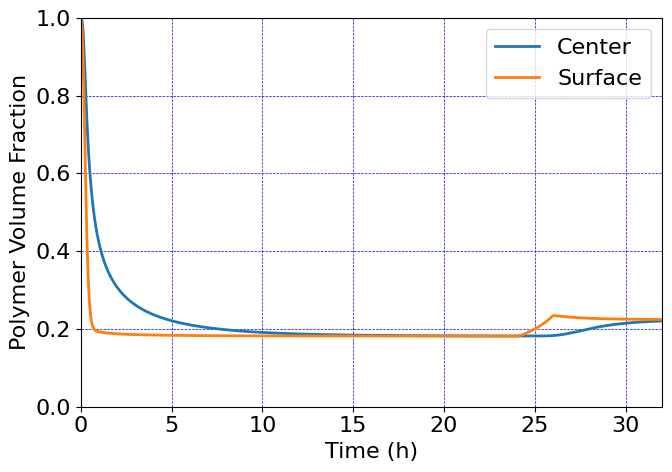

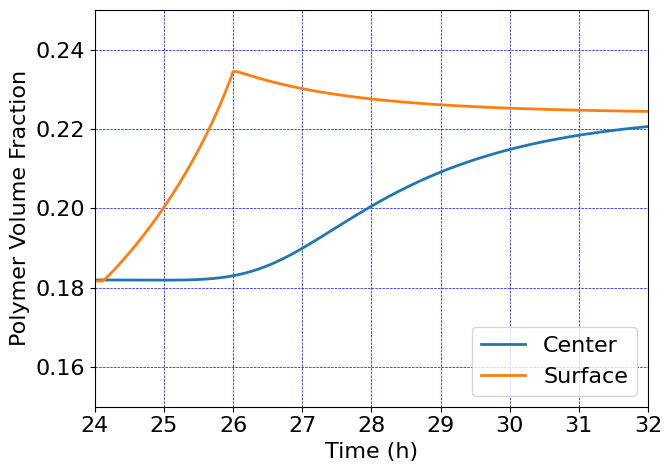

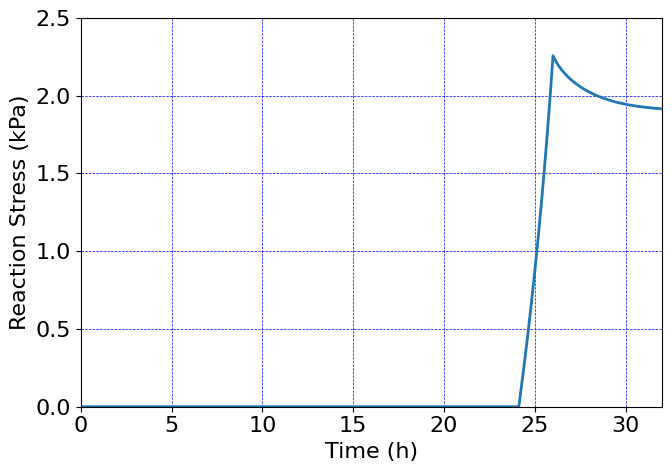

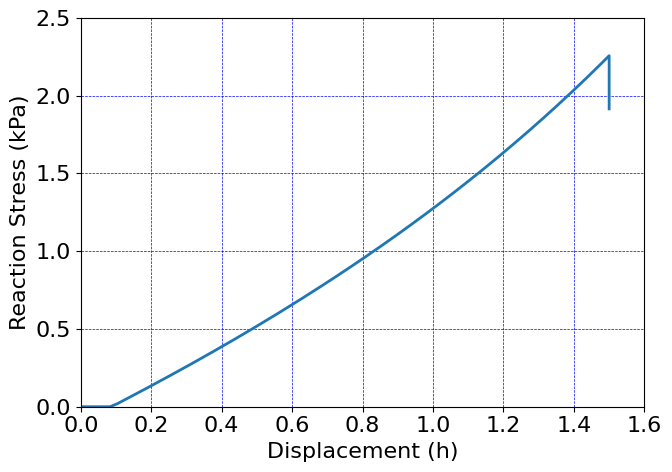

In [22]:
# set plot font to size 16
font = {'size'   : 16}
plt.rc('font', **font)

# Get array of default plot colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


# Only plot as far as we have time history data
ind = np.argmax(timeHist0) + 1


time = timeHist0[0:ind]
phiCenter = timeHist1[0:ind]
phiSurf = timeHist2[0:ind]
ReactForce = timeHist3[0:ind]
ReactStress = ReactForce/(np.pi*R0*R0)
disp = np.abs(timeHist4[0:ind])



fig = plt.figure()
plt.plot( time/3600.0, phiCenter, color=colors[0], linewidth=2.0, label=r'Center')
plt.plot( time/3600.0, phiSurf, color=colors[1], linewidth=2.0, label=r'Surface')
plt.grid(linestyle="--", linewidth=0.5, color='b')
plt.xlim([0,Ttot/3600.0])
plt.ylim([0,1])
plt.legend(loc="upper right")
plt.xlabel('Time (h)')
plt.ylabel('Polymer Volume Fraction')

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/axi_compression_phi.png", dpi=600)



fig = plt.figure()
plt.plot( time/3600.0, phiCenter, color=colors[0], linewidth=2.0, label=r'Center')
plt.plot( time/3600.0, phiSurf, color=colors[1], linewidth=2.0, label=r'Surface')
plt.grid(linestyle="--", linewidth=0.5, color='b')
plt.xlim([tSwell/3600.0,Ttot/3600.0])
plt.ylim([0.15,0.25])
plt.legend(loc="lower right")
plt.xlabel('Time (h)')
plt.ylabel('Polymer Volume Fraction')

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/axi_compression_phiZoom.png", dpi=600)



fig = plt.figure()
plt.plot( time/3600.0, ReactStress, color=colors[0], linewidth=2.0)
plt.grid(linestyle="--", linewidth=0.5, color='b')
plt.xlim([0,Ttot/3600.0])
plt.ylim([0,2.5])
plt.xlabel('Time (h)')
plt.ylabel('Reaction Stress (kPa)')

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/axi_compression_force_time.png", dpi=600)




fig = plt.figure()
plt.plot( disp, ReactStress, color=colors[0], linewidth=2.0)
plt.grid(linestyle="--", linewidth=0.5, color='b')
plt.xlim([0,1.6])
plt.ylim([0,2.5])
plt.xlabel('Displacement (h)')
plt.ylabel('Reaction Stress (kPa)')

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/axi_compression_force_disp.png", dpi=600)

In [ ]:
# np.savetxt('SwellThenCompress.csv', np.vstack((time,phiCenter,phiSurf,ReactForce,ReactStress,disp)).T, delimiter=',')